In [ ]:
# Программа для объединения датасетов из изначальных train и valid папок и выбора из них 15% данных с помощью стратификации с эмбедингами

import os
import json
import random
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [11]:
# Датасет для COCO формата
class COCODetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        # Загружаем аннотации
        anno_path = self.root_dir / "_annotations.coco.json"
        with open(anno_path, 'r') as f:
            self.coco_data = json.load(f)
        
        self.image_id_to_info = {img['id']: img for img in self.coco_data['images']}
        self.category_id_to_name = {cat['id']: cat['name'] for cat in self.coco_data['categories']}
        
        self.image_id_to_annotations = defaultdict(list)
        for ann in self.coco_data['annotations']:
            self.image_id_to_annotations[ann['image_id']].append(ann)
        
        self.image_ids = list(self.image_id_to_info.keys())
        
        # Получаем пути для изображений
        self.image_paths = []
        for img_id in self.image_ids:
            img_info = self.image_id_to_info[img_id]
            self.image_paths.append(self.root_dir / img_info['file_name'])
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image_id = self.image_ids[idx]
        
        image = read_image(str(img_path)).float() / 255.0

        annotations = self.image_id_to_annotations[image_id]
        
        boxes = []
        labels = []
        
        for ann in annotations:
            # [x_min, y_min, width, height]
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([image_id]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [12]:
# Создание объединенного датасета из train и valid
def create_combined_dataset(data_root="data_orig"):
    data_root = Path(data_root)
    
    train_dataset = COCODetectionDataset(data_root / "train")
    valid_dataset = COCODetectionDataset(data_root / "valid")
    
    class CombinedDataset(Dataset):
        def __init__(self, datasets):
            self.datasets = datasets
            self.cumulative_sizes = []
            total = 0
            for dataset in datasets:
                total += len(dataset)
                self.cumulative_sizes.append(total)
        
        def __len__(self):
            return self.cumulative_sizes[-1]
        
        def __getitem__(self, idx):
            dataset_idx = 0
            for i, size in enumerate(self.cumulative_sizes):
                if idx < size:
                    dataset_idx = i
                    break
            
            if dataset_idx > 0:
                idx -= self.cumulative_sizes[dataset_idx - 1]
            
            return self.datasets[dataset_idx][idx]
    
    combined_dataset = CombinedDataset([train_dataset, valid_dataset])
    
    print(f"Размер train датасета: {len(train_dataset)}")
    print(f"Размер valid датасета: {len(valid_dataset)}")
    print(f"Общий размер датасета: {len(combined_dataset)}")
    
    return combined_dataset, train_dataset, valid_dataset

combined_dataset, train_dataset, valid_dataset = create_combined_dataset()

Размер train датасета: 8691
Размер valid датасета: 2483
Общий размер датасета: 11174


In [ ]:
# Функция для извлечения эмбедингов
def extract_embeddings(dataset, batch_size=16, sample_size=None):

    print("🧠 Извлекаем эмбединги...")
    
    # Используем предобученный ResNet18
    resnet = models.resnet18(pretrained=True)
    resnet = resnet.to(device)
    resnet.eval()
    
    feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    
    # Функция для извлечения эмбедингов
    def extract_batch_embeddings(images):
        with torch.no_grad():
            if images.dim() == 3:
                images = images.unsqueeze(0)
            
            normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
            images = normalize(images)
            
            x = feature_extractor(images)  # [B, 512, 1, 1]
            x = x.view(x.size(0), -1)      # [B, 512]
        return x
    
    all_embeddings = []
    all_indices = []
    
   
    total_samples = min(len(dataset), sample_size) if sample_size else len(dataset)
    indices = list(range(total_samples))
    
    print(f"Извлекаем эмбединги для {total_samples} изображений...")
    
    # Извлекаем эмбединги батчами
    for i in tqdm(range(0, total_samples, batch_size), desc="Извлечение эмбедингов"):
        batch_indices = indices[i:min(i + batch_size, total_samples)]
        batch_images = []
        
        for idx in batch_indices:
            image, _ = dataset[idx]
            batch_images.append(image)
        
        # Конвертируем в тензор
        batch_tensor = torch.stack(batch_images).to(device)
        
        # Извлекаем эмбединги
        embeddings = extract_batch_embeddings(batch_tensor)
        all_embeddings.append(embeddings.cpu())
        all_indices.extend(batch_indices)
    
    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()
    
    print(f"Извлечено эмбедингов: {all_embeddings.shape}")
    print(f"Размерность эмбединга: {all_embeddings.shape[1]}")
    
    return all_embeddings, all_indices

In [ ]:
embeddings, indices = extract_embeddings(
    combined_dataset, 
    batch_size=4,
    sample_size=len(combined_dataset)
)

🧠 Извлекаем эмбединги...
Извлекаем эмбединги для 11174 изображений...


Извлечение эмбедингов: 100%|██████████| 2794/2794 [57:25<00:00,  1.23s/it]  


Извлечено эмбедингов: (11174, 512)
Размерность эмбединга: 512


In [15]:
# K-means кластеризация

n_clusters = min(10, len(indices) // 20) 
n_clusters = max(2, n_clusters)

print(f"Используем {n_clusters} кластеров")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
pseudo_labels = kmeans.fit_predict(embeddings)

print(f"Создано {n_clusters} кластеров")

cluster_counts = Counter(pseudo_labels)
for cluster_id in range(n_clusters):
    count = cluster_counts.get(cluster_id, 0)
    percentage = count / len(pseudo_labels) * 100
    print(f"Кластер {cluster_id}: {count} образцов")

Используем 10 кластеров
Создано 10 кластеров
Кластер 0: 1549 образцов
Кластер 1: 1031 образцов
Кластер 2: 1321 образцов
Кластер 3: 557 образцов
Кластер 4: 1243 образцов
Кластер 5: 722 образцов
Кластер 6: 1282 образцов
Кластер 7: 959 образцов
Кластер 8: 1913 образцов
Кластер 9: 597 образцов


PCA объясняет 0.597 дисперсии


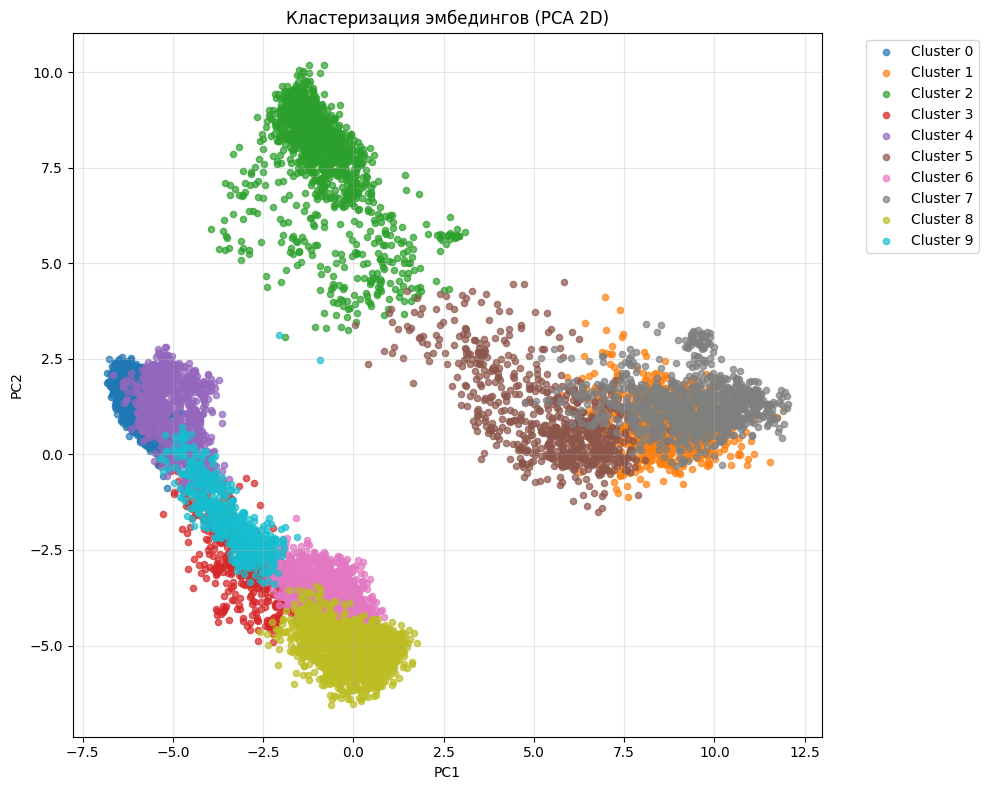

In [16]:
# Визуализация кластеров с помощью PCA

pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)

print(f"PCA объясняет {pca.explained_variance_ratio_.sum():.3f} дисперсии")

fig, ax = plt.subplots(figsize=(10, 8))

# Визуализация по кластерам
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))
for cluster in range(n_clusters):
    cluster_indices = np.where(pseudo_labels == cluster)[0]
    ax.scatter(emb_2d[cluster_indices, 0], emb_2d[cluster_indices, 1], 
               c=[colors[cluster]], label=f'Cluster {cluster}', s=20, alpha=0.7)

ax.set_title("Кластеризация эмбедингов (PCA 2D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [17]:
# Стратифицированная выборка 15% данных

# Определяем сколько нужно выбрать
total_samples = len(indices)
target_samples = int(total_samples * 0.15)

print(f"Всего образцов: {total_samples}")

sss = StratifiedShuffleSplit(
    n_splits=1, 
    test_size=target_samples,
    random_state=42
)

for _, selected_indices in sss.split(np.zeros(len(pseudo_labels)), pseudo_labels):
    selected_indices = selected_indices
    
print(f"Выбрано {len(selected_indices)} образцов")

selected_dataset_indices = [indices[i] for i in selected_indices]
selected_pseudo_labels = [pseudo_labels[i] for i in selected_indices]

print()
print("Распределение выбранных образцов по кластерам:")
cluster_counts_selected = Counter(selected_pseudo_labels)
for cluster_id in range(n_clusters):
    count = cluster_counts_selected.get(cluster_id, 0)
    percentage = count / len(selected_pseudo_labels) * 100
    total_in_cluster = cluster_counts.get(cluster_id, 0)
    percentage_of_cluster = count / total_in_cluster * 100 if total_in_cluster > 0 else 0
    
    print(f"Кластер {cluster_id}: {count} образцов")

Всего образцов: 11174
Выбрано 1676 образцов

Распределение выбранных образцов по кластерам:
Кластер 0: 232 образцов
Кластер 1: 155 образцов
Кластер 2: 198 образцов
Кластер 3: 84 образцов
Кластер 4: 186 образцов
Кластер 5: 108 образцов
Кластер 6: 192 образцов
Кластер 7: 144 образцов
Кластер 8: 287 образцов
Кластер 9: 90 образцов


In [ ]:
# Cохранения выборки в отдельную папку
import shutil
from PIL import Image as PILImage

def save_stratified_dataset(original_datasets, selected_indices, output_dir="stratified_data"):
    
    # Создаем структуру папок
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True, parents=True)
    
    images_dir = output_path
    images_dir.mkdir(exist_ok=True)
    
    coco_output = {
        "info": {},
        "licenses": [],
        "categories": [],
        "images": [],
        "annotations": []
    }
    
    # Получаем оригинальные COCO данные
    original_coco_data = {}
    for dataset_name in ["train", "valid"]:
        dataset_path = Path("data_orig") / dataset_name
        anno_path = dataset_path / "_annotations.coco.json"
        
        if anno_path.exists():
            with open(anno_path, 'r') as f:
                original_coco_data[dataset_name] = json.load(f)
    
    # Собираем категории из оригинальных датасетов
    all_categories = {}
    for dataset_name, coco_data in original_coco_data.items():
        for category in coco_data['categories']:
            cat_id = category['id']
            if cat_id not in all_categories:
                all_categories[cat_id] = category
    
    coco_output['categories'] = list(all_categories.values())
    

    new_image_id = 1
    new_annotation_id = 1
    image_id_mapping = {}
    

    for i, original_idx in enumerate(tqdm(selected_indices, desc="Сохранение изображений и аннотаций")):
        
        if original_idx < len(train_dataset):
            dataset_name = "train"
            dataset_idx = original_idx
            original_dataset = train_dataset
        else:
            dataset_name = "valid"
            dataset_idx = original_idx - len(train_dataset)
            original_dataset = valid_dataset
        
        # Получаем информацию об изображении из оригинального датасета
        original_coco = original_coco_data[dataset_name]
        
        image_info = None
        for img in original_coco['images']:
            img_path = Path(img['file_name'])
            if img_path.stem in str(original_dataset.image_paths[dataset_idx]):
                image_info = img
                break
        
        # Копируем изображение
        original_image_path = Path("data_orig") / dataset_name / image_info['file_name']
        new_image_filename = f"img_{new_image_id:06d}{original_image_path.suffix}"
        new_image_path = images_dir / new_image_filename
        
        try:
            shutil.copy2(original_image_path, new_image_path)
        except Exception as e:
            print(f"{original_image_path}: {e}")
            continue
        
        new_image_info = {
            "id": new_image_id,
            "file_name": new_image_filename,
            "width": image_info['width'],
            "height": image_info['height'],
            "original_dataset": dataset_name,
            "original_image_id": image_info['id'] }
        coco_output['images'].append(new_image_info)
        
        image_id_mapping[(dataset_name, image_info['id'])] = new_image_id
        
        # Находим и добавляем аннотации изображения
        original_annotations = []
        for ann in original_coco['annotations']:
            if ann['image_id'] == image_info['id']:
                original_annotations.append(ann)
        
        for ann in original_annotations:
            new_annotation = {
                "id": new_annotation_id,
                "image_id": new_image_id,
                "category_id": ann['category_id'],
                "bbox": ann['bbox'],
                "area": ann['area'],
                "segmentation": ann.get('segmentation', []),
                "iscrowd": ann.get('iscrowd', 0),
                "original_annotation_id": ann['id'] }
            coco_output['annotations'].append(new_annotation)
            new_annotation_id += 1
        
        new_image_id += 1
    
    annotations_path = output_path / "_annotations.coco.json"
    with open(annotations_path, 'w') as f:
        json.dump(coco_output, f, indent=2)
    
    
    print(f"\nСтратифицированная выборка сохранена в: {output_path}")
    print(f"   Изображений: {new_image_id - 1}")
    print(f"   Аннотаций: {new_annotation_id - 1}")
    
    return output_path

# Сохраняем выборку
output_dir = save_stratified_dataset(
    original_datasets=[train_dataset, valid_dataset],
    selected_indices=selected_dataset_indices,
    output_dir="stratified_15percent"
)

# Из папки test аналогичным образом, с помощью стратификации с эмбедингами, было отобрано 397 картинок

Сохранение изображений и аннотаций: 100%|██████████| 1676/1676 [03:12<00:00,  8.72it/s]



Стратифицированная выборка сохранена в: stratified_15percent
   Изображений: 1676
   Аннотаций: 96248
